# Linear Regression Model Training
### Read in features and labels
### Do some multivariate linear regression
### See how good the fits are
### Make some plots of the final WhereSIOUS scores & print some stats

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from sklearn import cross_validation

%matplotlib inline

In [188]:
# define extra bit for filenames for codes w/ # businesses >3000 (equivalently >2100)
extras = ['54','81','45','62','56','44','72','53']
# add codes w/ # businesses <2100 & >500
#extras = [extras, ]'42','23','48','61','71','52','51','33']
# add codes w/ # businesses <500 & >50
#extras = [extras, '32','31','49','55','11']
# add codes w/ # businesses <50
#extras = [extras, '22','92','21']

# pick which code to look at
i = 7
extra = '_'+extras[i]

In [189]:
# save min/max of business age
bus_ages = pd.read_csv('data_final/sd_active_businesses_cleaned.csv')
# use only current business code
bus_ages = bus_ages[bus_ages.naics_code_simple==float(extras[i])]
# drop tract 9902 (mostly SD Harbor, not much land) is always best tract, w/ only 3 quite old businesses (10-30 yr)
bus_ages = bus_ages[bus_ages.census_tract != 9902]

# get median ages in each tract
med_ages = bus_ages.groupby('census_tract').median().days_since_creation
bus_age_min = min(med_ages)/365.
bus_age_max = max(med_ages)/365.
print bus_age_min
print bus_age_max

0.690410958904
23.3178082192


In [190]:
# read in features and labels/examples (see build_features_labels2.ipynb for more info)
features = pd.read_csv('data_final/features'+extra+'.csv')
print features.shape
print features.columns
features[-100:]

(249, 26)
Index([u'census_tract', u'bus_age', u'n_business', u'population',
       u'population_percent_male', u'population_percent_female', u'age_med',
       u'age_med_male', u'age_med_female', u'minor_percent', u'adult_percent',
       u'homes', u'homes_percent_mortgage', u'homes_percent_clear',
       u'homes_percent_rent', u'employment_percent', u'income_med',
       u'income_med_owner', u'income_med_renter', u'cost_med',
       u'cost_med_owner', u'cost_med_renter', u'walk_score', u'transit_score',
       u'bike_score', u'total_amount'],
      dtype='object')


,census_tract,bus_age,n_business,population,population_percent_male,population_percent_female,age_med,age_med_male,age_med_female,minor_percent,...,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,walk_score,transit_score,bike_score,total_amount
149,8354,0.200993,0.048485,0.332364,0.397294,0.602706,0.301724,0.315517,0.259528,0.471463,...,0.621941,0.559662,0.418956,0.600054,0.61475,1.0000,0.422680,0.345679,0.595238,0.000000
150,8355,0.872866,0.012121,0.183690,0.381104,0.618896,0.315517,0.310345,0.288566,0.486302,...,0.597833,0.579878,0.446744,0.604393,0.58475,0.9610,0.422680,0.345679,0.595238,0.000000
151,8356,0.050793,0.006061,0.198745,0.379445,0.620555,0.310345,0.310345,0.286751,0.400961,...,0.488088,0.433680,0.394183,0.444957,0.44625,0.8095,0.422680,0.345679,0.595238,0.000000
152,8357,0.341567,0.018182,0.239578,0.390448,0.609552,0.322414,0.308621,0.310345,0.420288,...,0.466785,0.442685,0.328525,0.462852,0.45825,0.8020,0.422680,0.345679,0.595238,0.000000
153,8358,0.140332,0.024242,0.365555,0.395318,0.604682,0.368966,0.344828,0.357532,0.398160,...,0.450580,0.413916,0.362819,0.472343,0.42725,0.8500,0.422680,0.345679,0.595238,0.000000
154,8359,0.276244,0.018182,0.218477,0.461941,0.538059,0.227586,0.248276,0.172414,0.347853,...,0.312897,0.309045,0.284148,0.372289,0.31550,0.6940,0.422680,0.345679,0.595238,0.000000
155,8360,0.374501,0.115152,0.325806,0.367480,0.632520,0.300000,0.296552,0.279492,0.403353,...,0.448376,0.486393,0.310824,0.439534,0.46900,0.7265,0.422680,0.345679,0.595238,0.000000
156,8364,0.158070,0.078788,0.276476,0.263887,0.736113,0.222414,0.248276,0.161525,0.168962,...,0.368825,0.415962,0.297727,0.489696,0.60550,0.8360,0.536082,0.555556,0.642857,0.000000
157,8365,0.145054,0.012121,0.161677,0.376446,0.623554,0.436207,0.436207,0.404719,0.541071,...,0.896752,0.744742,0.837012,0.728579,0.65875,1.0000,0.237113,0.160494,0.369048,0.000000
158,8366,0.373653,0.060606,0.327174,0.370590,0.629410,0.393103,0.401724,0.355717,0.584256,...,0.829820,0.729210,0.575438,0.682484,0.61575,1.0000,0.237113,0.160494,0.369048,0.000000


## Fit w/ all input features (using statsmodels)

In [191]:
# fit the data
#   + to use feature
#   - to remove feature
#   : to multiply 2 features
#   * to multiply 2 features *and* use both individually
#   C(<feature>) to make <feature> into dummy/categorical feature
formula_str = 'bus_age ~ n_business - n_businesses_11 - n_businesses_21 - n_businesses_22 ' \
                '- n_businesses_23 - n_businesses_31 - n_businesses_32 - n_businesses_33 - n_businesses_42 ' \
                '- n_businesses_44 - n_businesses_45 - n_businesses_48 - n_businesses_49 - n_businesses_51 ' \
                '- n_businesses_52 - n_businesses_53 - n_businesses_54 - n_businesses_55 - n_businesses_56 ' \
                '- n_businesses_61 - n_businesses_62 - n_businesses_71 - n_businesses_72 - n_businesses_81 ' \
                '- n_businesses_92 + population - population_percent_male + population_percent_female + age_med ' \
                '- age_med_male - age_med_female - minor_percent + adult_percent + homes - homes_percent_mortgage '\
                '- homes_percent_clear - homes_percent_rent + employment_percent + income_med - income_med_owner '\
                '- income_med_renter + cost_med - cost_med_owner - cost_med_renter + walk_score + transit_score '\
                '+ bike_score - total_amount'
#                '+ n_business:population + n_businesses_11:population + n_businesses_21:population + n_businesses_22:population ' \
#                '+ n_businesses_23:population + n_businesses_31:population + n_businesses_32:population + n_businesses_33:population + n_businesses_42:population ' \
#                '+ n_businesses_44:population + n_businesses_45:population + n_businesses_48:population + n_businesses_49:population + n_businesses_51:population ' \
#                '+ n_businesses_52:population + n_businesses_53:population + n_businesses_54:population + n_businesses_55:population + n_businesses_56:population ' \
#                '+ n_businesses_61:population + n_businesses_62:population + n_businesses_71:population + n_businesses_72:population + n_businesses_81:population ' \
#                '+ n_businesses_92:population'
#                '+ n_business:homes + n_businesses_11:homes + n_businesses_21:homes + n_businesses_22:homes ' \
#                '+ n_businesses_23:homes + n_businesses_31:homes + n_businesses_32:homes + n_businesses_33:homes + n_businesses_42:homes ' \
#                '+ n_businesses_44:homes + n_businesses_45:homes + n_businesses_48:homes + n_businesses_49:homes + n_businesses_51:homes ' \
#                '+ n_businesses_52:homes + n_businesses_53:homes + n_businesses_54:homes + n_businesses_55:homes + n_businesses_56:homes ' \
#                '+ n_businesses_61:homes + n_businesses_62:homes + n_businesses_71:homes + n_businesses_72:homes + n_businesses_81:homes ' \
#                '+ n_businesses_92:homes'
#                '+ n_business:income_med + n_businesses_11:income_med + n_businesses_21:income_med + n_businesses_22:income_med ' \
#                '+ n_businesses_23:income_med + n_businesses_31:income_med + n_businesses_32:income_med + n_businesses_33:income_med + n_businesses_42:income_med ' \
#                '+ n_businesses_44:income_med + n_businesses_45:income_med + n_businesses_48:income_med + n_businesses_49:income_med + n_businesses_51:income_med ' \
#                '+ n_businesses_52:income_med + n_businesses_53:income_med + n_businesses_54:income_med + n_businesses_55:income_med + n_businesses_56:income_med ' \
#                '+ n_businesses_61:income_med + n_businesses_62:income_med + n_businesses_71:income_med + n_businesses_72:income_med + n_businesses_81:income_med ' \
#                '+ n_businesses_92:income_med'
#                '+ n_business:cost_med + n_businesses_11:cost_med + n_businesses_21:cost_med + n_businesses_22:cost_med ' \
#                '+ n_businesses_23:cost_med + n_businesses_31:cost_med + n_businesses_32:cost_med + n_businesses_33:cost_med + n_businesses_42:cost_med ' \
#                '+ n_businesses_44:cost_med + n_businesses_45:cost_med + n_businesses_48:cost_med + n_businesses_49:cost_med + n_businesses_51:cost_med ' \
#                '+ n_businesses_52:cost_med + n_businesses_53:cost_med + n_businesses_54:cost_med + n_businesses_55:cost_med + n_businesses_56:cost_med ' \
#                '+ n_businesses_61:cost_med + n_businesses_62:cost_med + n_businesses_71:cost_med + n_businesses_72:cost_med + n_businesses_81:cost_med ' \
#                '+ n_businesses_92:cost_med'
#                '+ n_business:walk_score + n_businesses_11:walk_score + n_businesses_21:walk_score + n_businesses_22:walk_score ' \
#                '+ n_businesses_23:walk_score + n_businesses_31:walk_score + n_businesses_32:walk_score + n_businesses_33:walk_score + n_businesses_42:walk_score ' \
#                '+ n_businesses_44:walk_score + n_businesses_45:walk_score + n_businesses_48:walk_score + n_businesses_49:walk_score + n_businesses_51:walk_score ' \
#                '+ n_businesses_52:walk_score + n_businesses_53:walk_score + n_businesses_54:walk_score + n_businesses_55:walk_score + n_businesses_56:walk_score ' \
#                '+ n_businesses_61:walk_score + n_businesses_62:walk_score + n_businesses_71:walk_score + n_businesses_72:walk_score + n_businesses_81:walk_score ' \
#                '+ n_businesses_92:walk_score'
model = smf.ols(formula=formula_str, data=features).fit()

print len(model.params)
# print the coefficients
model.params

13


Intercept                    0.387947
n_business                   0.115817
population                  -0.325336
population_percent_female   -0.035042
age_med                     -0.006968
adult_percent               -0.010941
homes                        0.082430
employment_percent          -0.100820
income_med                   0.167264
cost_med                    -0.155418
walk_score                  -0.148617
transit_score                0.050468
bike_score                   0.107768
dtype: float64

In [192]:
# RMSE of model
pred = model.predict(features).values * (bus_age_max-bus_age_min) + bus_age_min
actual = features.bus_age.values * (bus_age_max-bus_age_min) + bus_age_min
RMSE = np.sqrt(np.sum((pred-actual)**2)/len(features))
print RMSE

# print a summary of the model
model.summary()

3.8407190335


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                bus_age   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.7968
Date:                Sun, 25 Sep 2016   Prob (F-statistic):              0.654
Time:                        01:14:57   Log-Likelihood:                 88.286
No. Observations:                 249   AIC:                            -150.6
Df Residuals:                     236   BIC:                            -104.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3879      0.160      2.429      0.016       0.073       0.703
n_business                    0.1158      0.108      1.070      0.286      -0.097       0.329
population                   -0.3253      0.230     -1.417      0.158      -0.778       0.127
population_percent_female    -0.0350      0.137     -0.256      0.798      -0.305       0.235
age_med                      -0.0070      0.123     -0.057      0.955      -0.249       0.235
adult_percent                -0.0109      0.111     -0.099      0.921      -0.229       0.207
homes                         0.0824      0.196      0.421      0.674      -0.303       0.468
employment_percent           -0.1008      0.117     -0.862      0.390      -0.331       0.130
income_med                    0.1673      0.184      0.909      0.365      -0.195       0.530
cost_med                     -0.1554      0.216     -0.721      0.472      -0.580       0.269
walk_score                   -0.1486      0.154     -0.966      0.335      -0.452       0.154
transit_score                 0.0505      0.120      0.420      0.675      -0.186       0.287
bike_score                    0.1078      0.126      0.854      0.394      -0.141       0.356
==============================================================================
Omnibus:                       80.189   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.213
Skew:                           1.459   Prob(JB):                     1.37e-46
Kurtosis:                       6.442   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Leave One Out Cross-Validation

In [193]:
# define LOO for looping purposes
loo = cross_validation.LeaveOneOut(len(features))

# initialize resulting RMSE
RMSE_loo = []

# go through each example as the hold-out
for train_index, test_index in loo:
    # train model
    model_loo = smf.ols(formula=formula_str, data=features.loc[train_index]).fit()
    # get result from hold-out
    prediction = model_loo.predict(features.loc[test_index])
    # rescale to actual years
    pred = prediction.values * (bus_age_max-bus_age_min) + bus_age_min
    actual = features.loc[test_index].bus_age.values * (bus_age_max-bus_age_min) + bus_age_min
    # save current result 
    RMSE_loo.append((abs(pred-actual))[0])

# take mean of all results
RMSE_loo_arr = np.array(RMSE_loo)
print "LOOCV (median): " + str(np.median(RMSE_loo_arr))
loocv = RMSE_loo_arr.mean()
print "LOOCV = " + str(loocv)

LOOCV (median): 2.45328881919
LOOCV = 3.00022866539


## Predict new ages for all census tracts

In [194]:
# read in features and labels/examples (see build_features_labels2.ipynb for more info)
features_all = pd.read_csv('data_final/features.csv')
features_all['n_business'] = features_all['n_businesses'+extra]
features_all = features_all.drop('n_businesses_11', 1)
features_all = features_all.drop('n_businesses_21', 1)
features_all = features_all.drop('n_businesses_22', 1)
features_all = features_all.drop('n_businesses_23', 1)
features_all = features_all.drop('n_businesses_31', 1)
features_all = features_all.drop('n_businesses_32', 1)
features_all = features_all.drop('n_businesses_33', 1)
features_all = features_all.drop('n_businesses_42', 1)
features_all = features_all.drop('n_businesses_44', 1)
features_all = features_all.drop('n_businesses_45', 1)
features_all = features_all.drop('n_businesses_48', 1)
features_all = features_all.drop('n_businesses_49', 1)
features_all = features_all.drop('n_businesses_51', 1)
features_all = features_all.drop('n_businesses_52', 1)
features_all = features_all.drop('n_businesses_53', 1)
features_all = features_all.drop('n_businesses_54', 1)
features_all = features_all.drop('n_businesses_55', 1)
features_all = features_all.drop('n_businesses_56', 1)
features_all = features_all.drop('n_businesses_61', 1)
features_all = features_all.drop('n_businesses_62', 1)
features_all = features_all.drop('n_businesses_71', 1)
features_all = features_all.drop('n_businesses_72', 1)
features_all = features_all.drop('n_businesses_81', 1)
features_all = features_all.drop('n_businesses_92', 1)
print features_all.shape
print features_all.columns
features_all[-90:-20]

(313, 26)
Index([u'census_tract', u'bus_age', u'n_business', u'population',
       u'population_percent_male', u'population_percent_female', u'age_med',
       u'age_med_male', u'age_med_female', u'minor_percent', u'adult_percent',
       u'homes', u'homes_percent_mortgage', u'homes_percent_clear',
       u'homes_percent_rent', u'employment_percent', u'income_med',
       u'income_med_owner', u'income_med_renter', u'cost_med',
       u'cost_med_owner', u'cost_med_renter', u'walk_score', u'transit_score',
       u'bike_score', u'total_amount'],
      dtype='object')


,census_tract,bus_age,n_business,population,population_percent_male,population_percent_female,age_med,age_med_male,age_med_female,minor_percent,...,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,walk_score,transit_score,bike_score,total_amount
223,9602,0.517017,0.048193,0.207072,0.170491,0.829509,0.501695,0.470187,0.532203,0.305602,...,0.364353,0.278705,0.308249,0.341106,0.27775,0.8030,0.391753,0.333333,0.357143,0.0
224,9603,0.537511,0.102410,0.250299,0.175148,0.824852,0.286441,0.301533,0.274576,0.171768,...,0.300499,0.235417,0.263624,0.358189,0.30975,0.6665,0.000000,0.000000,0.000000,0.0
225,9604,0.456052,0.090361,0.173082,0.176037,0.823963,0.391525,0.386712,0.403390,0.369224,...,0.384174,0.309381,0.327815,0.357918,0.42875,0.6035,0.000000,0.000000,0.000000,0.0
226,9703,0.493045,0.066265,0.188309,0.172326,0.827674,0.491525,0.488927,0.491525,0.356553,...,0.418274,0.360997,0.294040,0.483460,0.37925,1.0000,0.391753,0.333333,0.357143,0.0
227,9704,0.525007,0.024096,0.319703,0.158088,0.841912,0.466102,0.459966,0.467797,0.340410,...,0.499699,0.406319,0.367295,0.389100,0.35950,0.7165,0.278351,0.197531,0.369048,0.0
228,9705,0.432968,0.054217,0.200057,0.173793,0.826207,0.445763,0.431005,0.455932,0.388443,...,0.561951,0.430100,0.382781,0.422993,0.36000,0.8470,0.226804,0.444444,0.214286,0.0
229,9706,0.486091,0.144578,0.390761,0.161064,0.838936,0.576271,0.563884,0.586441,0.333908,...,0.611469,0.505394,0.237526,0.390727,0.36125,0.7190,0.278351,0.197531,0.369048,0.0
230,9801,0.538917,0.036145,0.270887,0.165369,0.834631,0.484746,0.451448,0.515254,0.331620,...,0.333441,0.359968,0.184482,0.370119,0.30800,0.7155,0.443299,0.358025,0.500000,0.0
231,9802,0.440663,0.024096,0.339721,0.172559,0.827441,0.352542,0.335605,0.374576,0.388074,...,0.356392,0.321293,0.215746,0.365781,0.31100,0.6860,0.443299,0.358025,0.500000,0.0
232,9804,0.459455,0.018072,0.263986,0.162655,0.837345,0.484746,0.478705,0.491525,0.379354,...,0.409087,0.339736,0.337748,0.515727,0.44625,1.0000,0.443299,0.358025,0.500000,0.0


In [195]:
# make predictions for this code for all tracts
bus_age_pred_final = model.predict(features_all)
tracts_final = features_all.census_tract.values

# recalc model output ages
bus_age_pred = model.predict(features)
tracts = features.census_tract
#print bus_age_pred[:20]
#print bus_age_pred_final[:20]

In [196]:
# check stuff that will be saved
print tracts_final.shape
#print tracts_final[:400]
print bus_age_pred_final.shape
#bus_age_pred_final[:400]

(313,)
(313,)


## Plot ages, model output ages, and model output ages for adding a business to each tract/code combo

(249,)
(249,)
0.254242785405
0.253031906398
0.0341654163208

(313,)
0.244767805632
0.243814886681
0.0356308602299


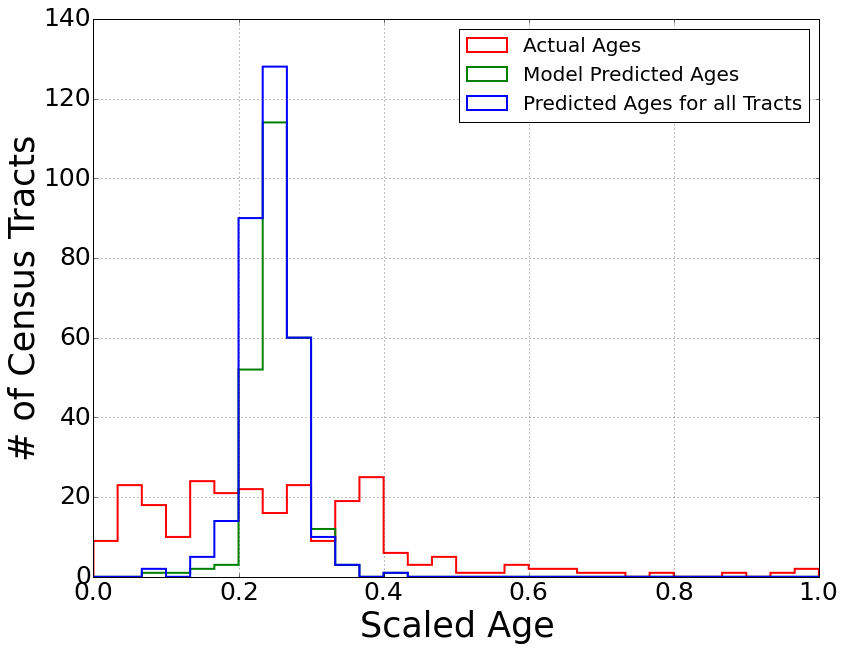

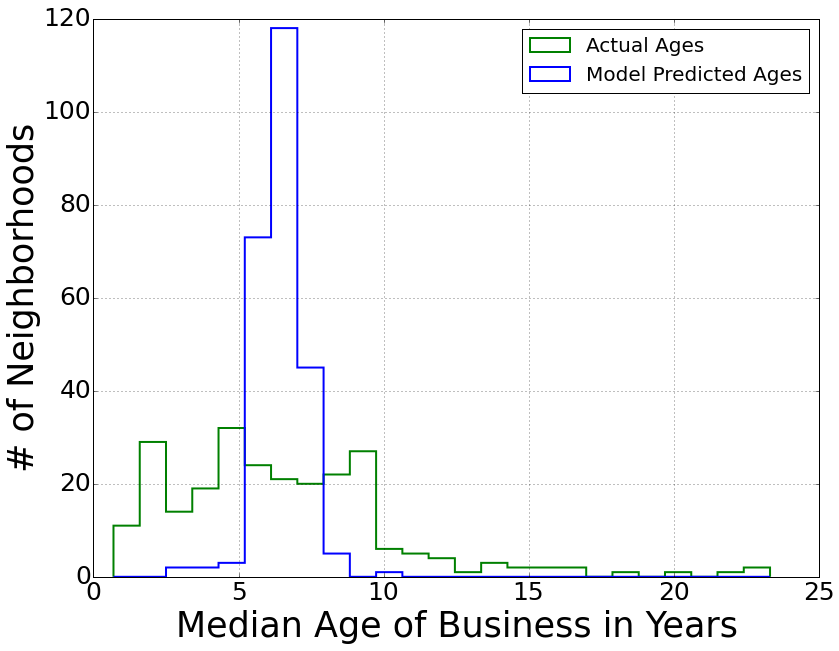

In [197]:
# make histogram of scaled ages input and output and final output (for each business/tract combo)
plt.figure(figsize=(13, 10))
plt.hist([bus_age_pred_final,bus_age_pred,features.bus_age], bins=30, histtype='step', align='mid', linewidth=2, \
         label=['Predicted Ages for all Tracts','Model Predicted Ages','Actual Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Scaled Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# unscale actual busisness ages
t1 = features.bus_age * (bus_age_max-bus_age_min) + bus_age_min
# unscale predicted busisness ages
t2 = bus_age_pred * (bus_age_max-bus_age_min) + bus_age_min

plt.figure(figsize=(13, 10))
plt.hist([t2,t1], bins=25, histtype='step', align='mid', linewidth=2, \
         label=['Model Predicted Ages','Actual Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Median Age of Business in Years',fontsize=35)
plt.ylabel('# of Neighborhoods',fontsize=35)

# print some stats about the model output
print features.bus_age.shape
print bus_age_pred.shape
print np.mean(bus_age_pred)
print np.median(bus_age_pred)
print np.std(bus_age_pred)
print

# print some stats about the model output for each tract/code combo
print bus_age_pred_final.shape
print np.mean(bus_age_pred_final)
print np.median(bus_age_pred_final)
print np.std(bus_age_pred_final)

## Save newly made lists of tract/code combos and scores and diff to dataframes

In [198]:
# scale ages to 0 to 100 to get WhereSIOUS score
#print min(bus_age_pred_final)
#print max(bus_age_pred_final)
#score = 100 * (bus_age_pred_final-min(bus_age_pred_final)) / (max(bus_age_pred_final)-min(bus_age_pred_final))
print min(bus_age_pred)
print max(bus_age_pred)
score = 100 * (bus_age_pred-min(bus_age_pred)) / (max(bus_age_pred)-min(bus_age_pred))
print min(score)
print max(score)

# scale scores again with a logistic function to spread them out more evenly
score = score/(1+3/np.std(score)*np.exp(-2/np.std(score)*(score-np.mean(score))))
print min(score)
print max(score)

# save lists of tracts and final predicted ages as a dataframe
#df_ages = pd.DataFrame({'census_tract': tracts_final, 'score': score})
df_ages = pd.DataFrame({'census_tract': tracts, 'score': score})
print df_ages.shape
#print df_ages[:538]

0.0920756691133
0.416917313964
0.0
100.0
0.0
99.9979130354
(249, 2)


In [199]:
# write dataframe of tracts, codes, and scores to csv in data_final folder and in flask static folder
df_ages.to_csv('data_final/tracts_scores'+extra+'.csv')
df_ages.to_csv('wheresious/static/tracts_scores'+extra+'.csv')

## Make a histogram and do some stats on the WhereSIOUS scores

37.172838631
37.9341083177
18.4277305277


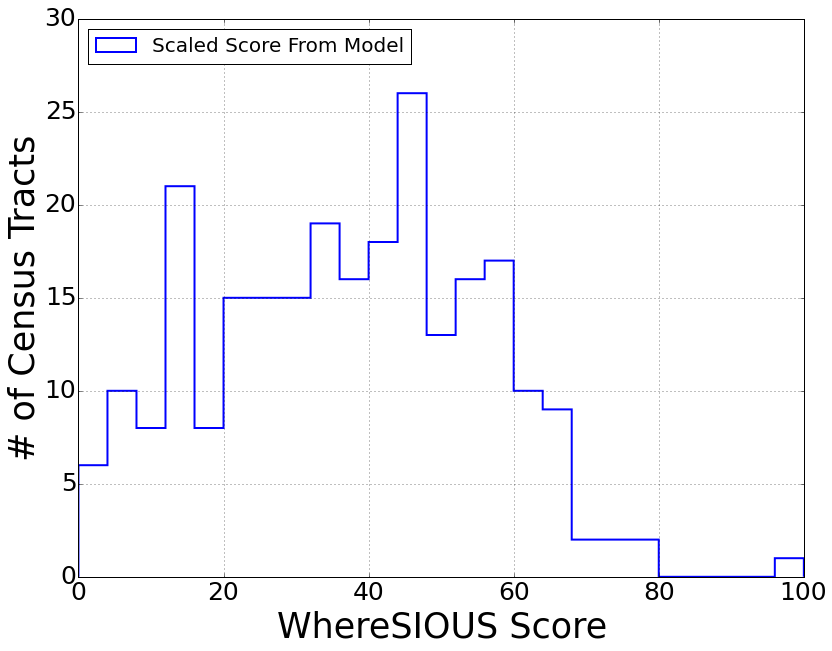

In [200]:
# make histogram of scores scaled 0 to 100
plt.figure(figsize=(13, 10))
plt.hist(df_ages.score, bins=25, histtype='step', align='mid', linewidth=2, \
         label=['Scaled Score From Model'])
plt.legend(loc=2,fontsize=20)
#plt.xlim(0,100)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('WhereSIOUS Score',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
mean = np.mean(df_ages.score)
print mean
print np.median(df_ages.score)
std = np.std(df_ages.score)
print std

In [201]:
# get max score
max_score = df_ages.score.max()
print df_ages[max_score==df_ages.score.values]
# get min score
min_score = df_ages.score.min()
print df_ages[min_score==df_ages.score.values]

     census_tract      score
168          8511  99.997913
     census_tract  score
211         10014    0.0


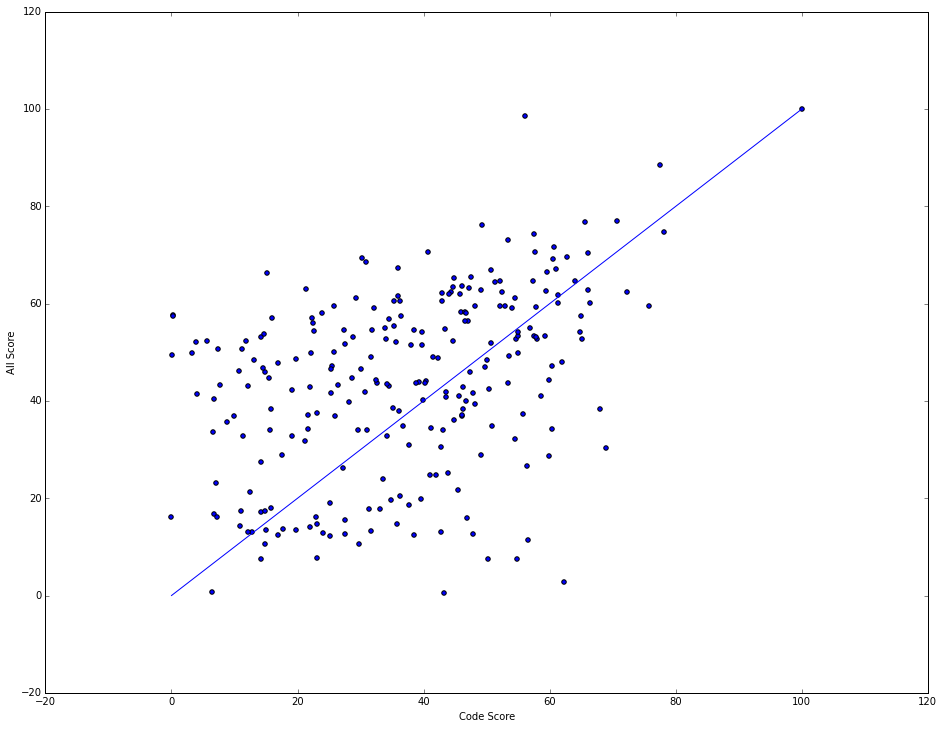

In [202]:
# read in scores for all businesses
temp = pd.read_csv('data_final/tracts_scores.csv',index_col=0)

plt.figure(figsize=(13, 10))
for index, row in df_ages.iterrows():
    plt.scatter(row['score'],temp[temp['census_tract']==row['census_tract']].score.values)
plt.plot([0,100],[0,100])
plt.tight_layout()
plt.xlabel('Code Score')
plt.ylabel('All Score')

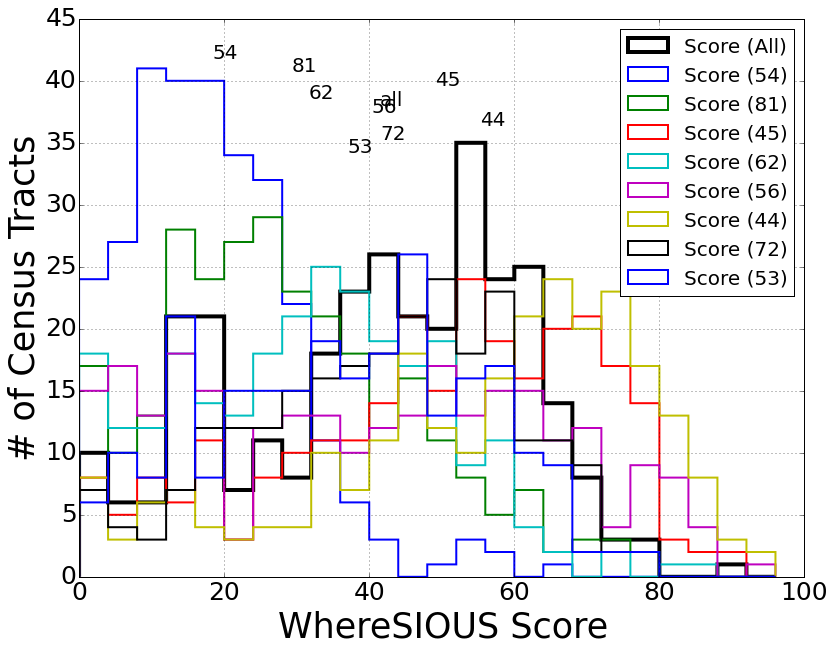

In [203]:
# plot histogram of all scores
plt.figure(figsize=(13, 10))
plt.hist(temp.score, bins=range(0,100,4), histtype='step', align='mid', linewidth=4, \
         label=['Score (All)'],color='k')
plt.text(np.mean(temp.score),38.,'all',fontsize=20)

# same for each specific code we've done
n=0
for extra in extras:
    temp = pd.read_csv('data_final/tracts_scores_'+extra+'.csv',index_col=0)
    plt.hist(temp.score, bins=range(0,100,4), histtype='step', align='mid', linewidth=2, \
         label=['Score ('+extra+')'])
    plt.text(np.mean(temp.score),38*((7-n)/35.+.9),extra,fontsize=20)
    n+=1

plt.legend(loc=0,fontsize=20)
#plt.xlim(0,100)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('WhereSIOUS Score',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)